In [1]:
suppressMessages(library(Seurat))
suppressMessages(library(edgeR))
suppressMessages(library(glue))
suppressMessages(library(stringr))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ComplexHeatmap))
suppressMessages(library(cowplot))
suppressMessages(library(ggrepel))
suppressMessages(library(tidyverse))
suppressMessages(library(org.Hs.eg.db))

In [2]:
## load metadata
metadata <- read.csv("../data/raw_integrated_update_metadata.csv", row.names = 1)

cell_id <- stringr::str_split_fixed(rownames(metadata), "-", 3)
metadata$cell_id <- paste0(cell_id[, 1], "-", cell_id[, 2])
metadata$cell_id <- paste0(metadata$cell_id, "-", metadata$sample_id)

head(metadata)

,sample_id,condition,batch,cell_type,Patient,CellType,Condition,Hypertrophy_score1,cell_id
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
AAACCCACAGACCATT-1-0,CK114,healthy,0,pericyte,YA5468,pericyte,Control,0.044507922,AAACCCACAGACCATT-1-CK114
AAACCCACAGTTAGGG-1-0,CK114,healthy,0,macrophages,YA5468,macrophages,Control,0.067826876,AAACCCACAGTTAGGG-1-CK114
AAACCCATCACCATGA-1-0,CK114,healthy,0,T-cells,YA5468,T-cells,Control,-0.002288659,AAACCCATCACCATGA-1-CK114
AAACCCATCAGTGGGA-1-0,CK114,healthy,0,endothelial,YA5468,endothelial,Control,0.008565140,AAACCCATCAGTGGGA-1-CK114
AAACGAAAGAGGCTGT-1-0,CK114,healthy,0,macrophages,YA5468,macrophages,Control,0.076609117,AAACGAAAGAGGCTGT-1-CK114
AAACGAAAGTAATACG-1-0,CK114,healthy,0,pericyte,YA5468,pericyte,Control,0.075014968,AAACGAAAGTAATACG-1-CK114


In [3]:
## load raw count matrix for all cells
sample_list <- unique(metadata$sample_id)
gex_mat <- lapply(sample_list, function(sample){
    data.dir <- glue::glue("../snRNA_cellranger/{sample}/outs/filtered_feature_bc_matrix.h5")
    data <- Read10X_h5(data.dir)

    colnames(data) <- paste0(colnames(data), "-", sample)
    
    return(data)
}) %>% Reduce(cbind, .)

gex_mat <- gex_mat[, metadata$cell_id]

Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in sparseMatrix(i = indices[] + 1, p = indptr[], x = as.numeric(x = counts[]), :
“'giveCsparse' has been deprecated; setting 'repr = "T"' for you”
Warning message in spa

In [4]:
get_bulk_mat <- function(gex_matrix, metadata, celltype, patients, min_cell_counts=5){
        
    bulk_mat <- list()
    patients_used <- list()
    idx <- 1
    
    for(patient in patients){
        metadata_sub <- subset(metadata, Patient == patient & CellType == celltype)
        if(nrow(metadata_sub) > min_cell_counts){
            bulk_mat[[idx]] <- rowSums(gex_matrix[, metadata_sub$cell_id]) %>%
            as.data.frame()
            patients_used[[idx]] <- patient 
            idx <- idx + 1
        }
    }

    bulk_mat <- Reduce(cbind, bulk_mat)
    colnames(bulk_mat) <- patients_used
    
    return(bulk_mat)
}

In [5]:
control_patients <- c("YA5468", "YHJ323", "YH5394", "YID393")
hf_a_patients <- c("YJM250", "YHC474", "YEI202", "YHN332", "YF2299")
hf_ckd_patients <- c("YKB285", "YFV238", "YFV428", "ZKY095")

celltype_list <- unique(metadata$cell_type)

In [6]:
## add information for patients
sample_id <- c("Control_YA5468", 
              "Control_YHJ323",
             "Control_YH5394",
             "Control_YID393",
             "HF_A_YJM250",
             "HF_A_YHC474",
             "HF_A_YEI202",
             "HF_A_YHN332",
             "HF_A_YF2299",
             "HF_CKD_YKB285",
             "HF_CKD_YFV238",
             "HF_CKD_YFV428",
             "HF_CKD_ZKY095")
age <- c(35, 60, 59, 46, 57, 60, 53, 51, 38, 62, 58, 55, 62)
df <- data.frame(sample_id = sample_id,
                 age = age)
head(df)

,sample_id,age
,<chr>,<dbl>
1,Control_YA5468,35
2,Control_YHJ323,60
3,Control_YH5394,59
4,Control_YID393,46
5,HF_A_YJM250,57
6,HF_A_YHC474,60


In [7]:
#celltype_list <- c("adipocytes")

In [19]:
for(celltype in celltype_list){
    message(glue::glue("find differential genes for {celltype}"))
    
    control_bulk_mat <- get_bulk_mat(gex_mat, metadata, 
                                     celltype, patients=control_patients)
    
    hf_a_bulk_mat <- get_bulk_mat(gex_mat, metadata, 
                                  celltype, patients=hf_a_patients)
    
    hf_ckd_bulk_mat <- get_bulk_mat(gex_mat, metadata, 
                                    celltype, patients=hf_ckd_patients)

    
    colnames(control_bulk_mat) <- paste0("Control", "_", colnames(control_bulk_mat))
    colnames(hf_a_bulk_mat) <- paste0("HF_A", "_", colnames(hf_a_bulk_mat))
    colnames(hf_ckd_bulk_mat) <- paste0("HF_CKD", "_", colnames(hf_ckd_bulk_mat))
    
    x <- cbind(control_bulk_mat, hf_a_bulk_mat, hf_ckd_bulk_mat)
    
    saveRDS(x, file = glue::glue("../data/PseudoMatrix/{celltype}.Rds"))
    
    group <- factor(c(rep("Control", ncol(control_bulk_mat)),
                      rep("HF_A", ncol(hf_a_bulk_mat)),
                      rep("HF_CKD", ncol(hf_ckd_bulk_mat)))) 
    
    
    # perform DA analysis using edgeR
    y <- DGEList(counts = x, group = group)

    # Filtering    
    keep <- filterByExpr(y, group = group)
    y <- y[keep, , keep.lib.sizes=FALSE]
    
    # Normalization
    y <- calcNormFactors(y, method = 'TMM')
    
    design <- model.matrix(~0 + group)
    colnames(design) <- levels(y$samples$group)
    rownames(design) <- colnames(y)
    
    y <- estimateDisp(y, design, robust=TRUE)
    saveRDS(y, glue::glue("../data/DEG/{celltype}.Rds"))
    
    fit <- glmFit(y, design)
    
    # compare hf_a vs. control
    con <- makeContrasts(HF_A - Control, levels = design)
    qlf <- glmLRT(fit, contrast = con)
    df <- qlf$table %>%
    as.data.frame() %>%
    rownames_to_column('gene')
    df$FDR <- p.adjust(df$PValue, method = "BH")
    
    
    df$description <- mapIds(x = org.Hs.eg.db,
                              keys = df$gene,
                              column = "GENENAME",
                              keytype = "SYMBOL",
                              multiVals = "first")
    df <- na.omit(df)
    
    saveRDS(df, glue::glue("../data/DEG/HF_A-Control-{celltype}.rds"))
    WriteXLS::WriteXLS(df,
                   ExcelFileName = glue::glue("../data/DEG/HF_A-Control-{celltype}.xlsx"))

    # compare hf_ckd vs. control
    con <- makeContrasts(HF_CKD - Control, levels = design)
    qlf <- glmLRT(fit, contrast = con)
    df <- qlf$table %>%
    as.data.frame() %>%
    rownames_to_column('gene')
    
    df$FDR <- p.adjust(df$PValue, method = "BH")
    
    df$description <- mapIds(x = org.Hs.eg.db,
                              keys = df$gene,
                              column = "GENENAME",
                              keytype = "SYMBOL",
                              multiVals = "first")
    df <- na.omit(df)
    
    saveRDS(df, glue::glue("../data/DEG/HF_CKD-Control-{celltype}.rds"))
    WriteXLS::WriteXLS(df,
                   ExcelFileName = glue::glue("../data/DEG/HF_CKD-Control-{celltype}.xlsx"))
    
    # compare hf_ckd vs. hf_a
    con <- makeContrasts(HF_CKD - HF_A, levels = design)
    qlf <- glmLRT(fit, contrast = con)
    df <- qlf$table %>%
    as.data.frame() %>%
    rownames_to_column('gene')
    
    df$FDR <- p.adjust(df$PValue, method = "BH")
    df$description <- mapIds(x = org.Hs.eg.db,
                              keys = df$gene,
                              column = "GENENAME",
                              keytype = "SYMBOL",
                              multiVals = "first")
    df <- na.omit(df)
    
    saveRDS(df, glue::glue("../data/DEG/HF_CKD-HF_A-{celltype}.rds"))
    WriteXLS::WriteXLS(df,
                   ExcelFileName = glue::glue("../data/DEG/HF_CKD-HF_A-{celltype}.xlsx"))
    
}

find differential genes for pericyte

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

find differential genes for macrophages

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

find differential genes for T-cells

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

find differential genes for endothelial

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

find differential genes for fibroblast

'select()' returned 1:many mapping between keys and columns

'select()'

Warning message:
“Removed 11274 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11289 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11015 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 270 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“Removed 12883 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 12880 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 12794 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 8 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 96 unlabeled data points (too many overlaps). C

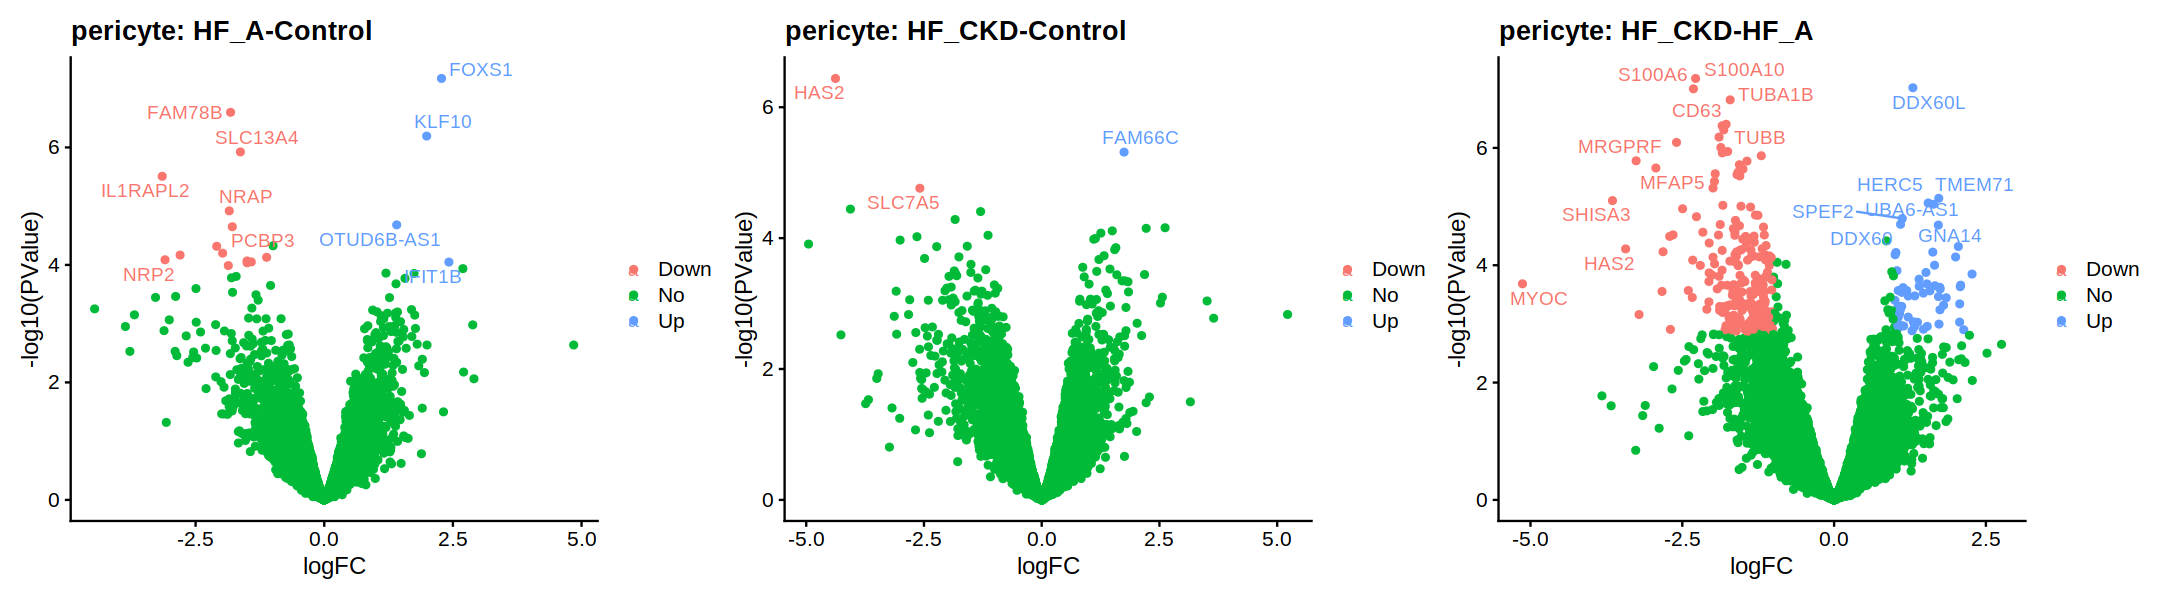

Warning message:
“Removed 8991 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 8918 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 8537 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 70 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 453 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 89 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


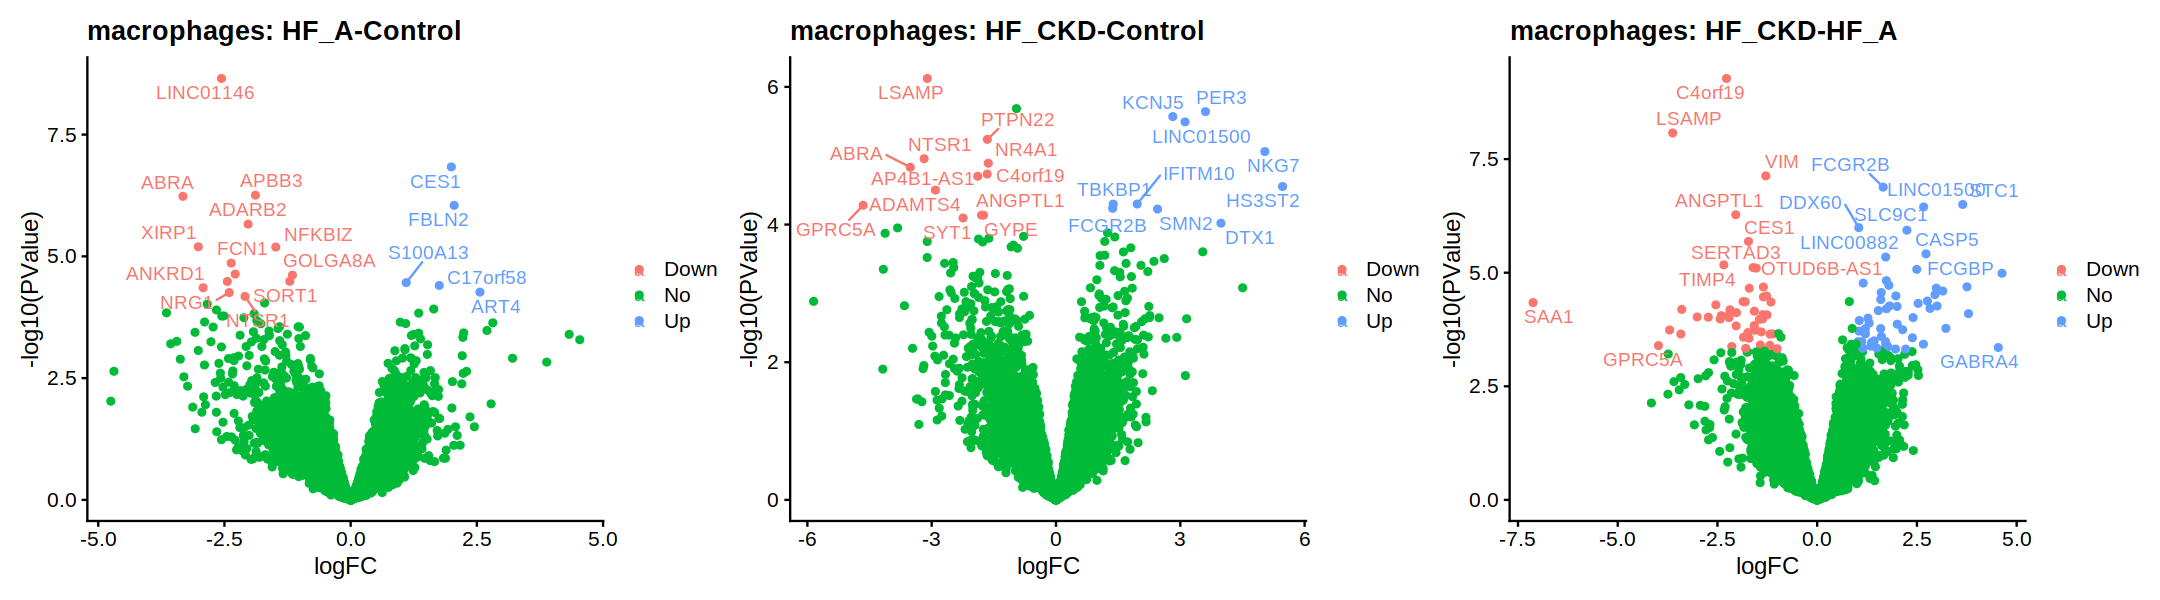

Warning message:
“Removed 11918 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11883 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11578 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 329 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 58 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 443 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


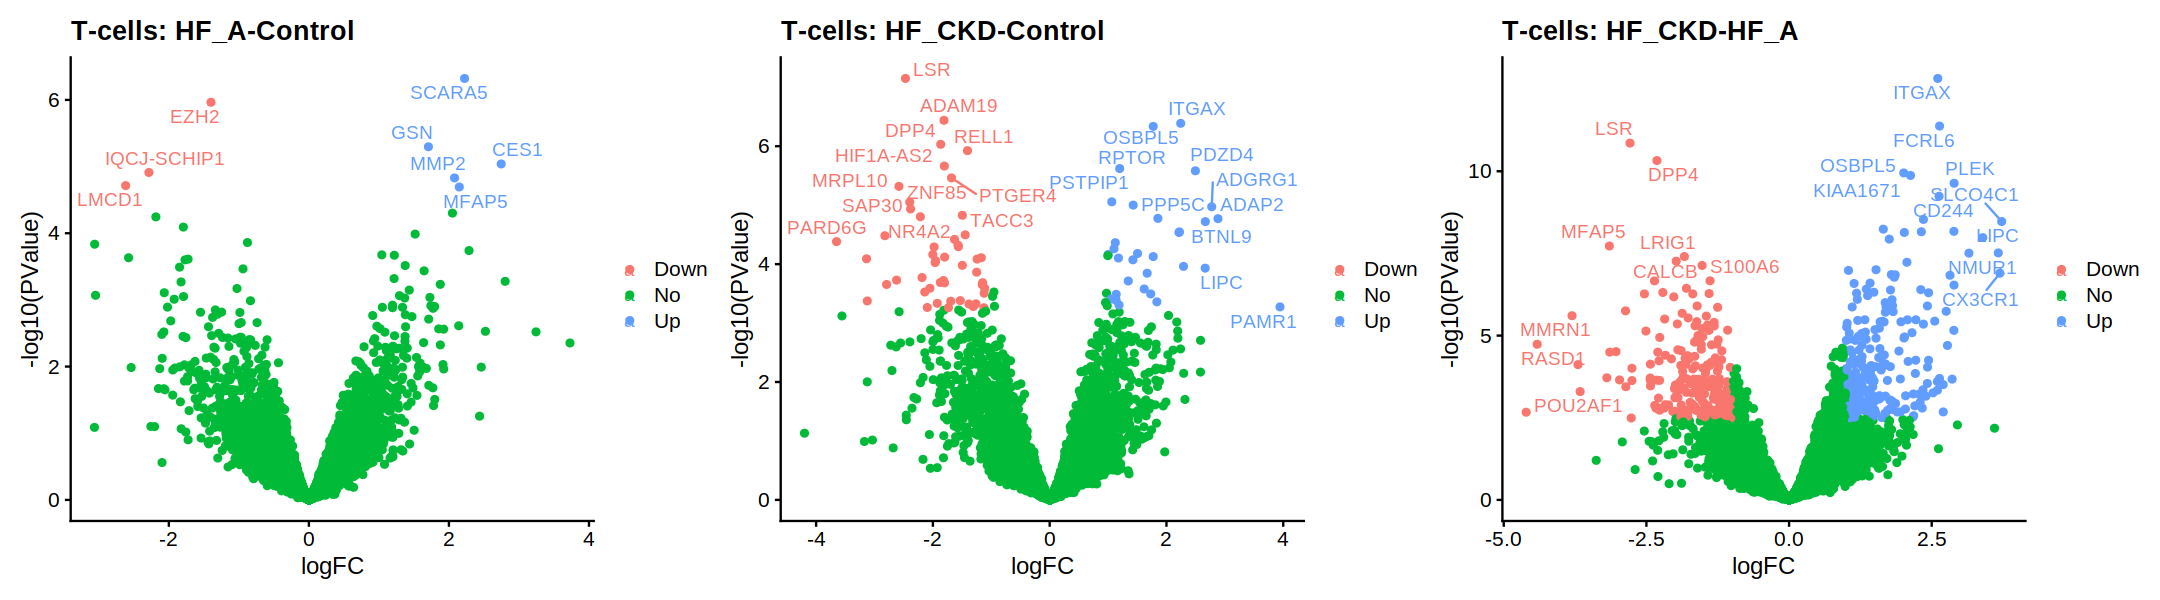

Warning message:
“Removed 14049 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 13941 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 13541 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 106 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 504 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 23 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 321 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


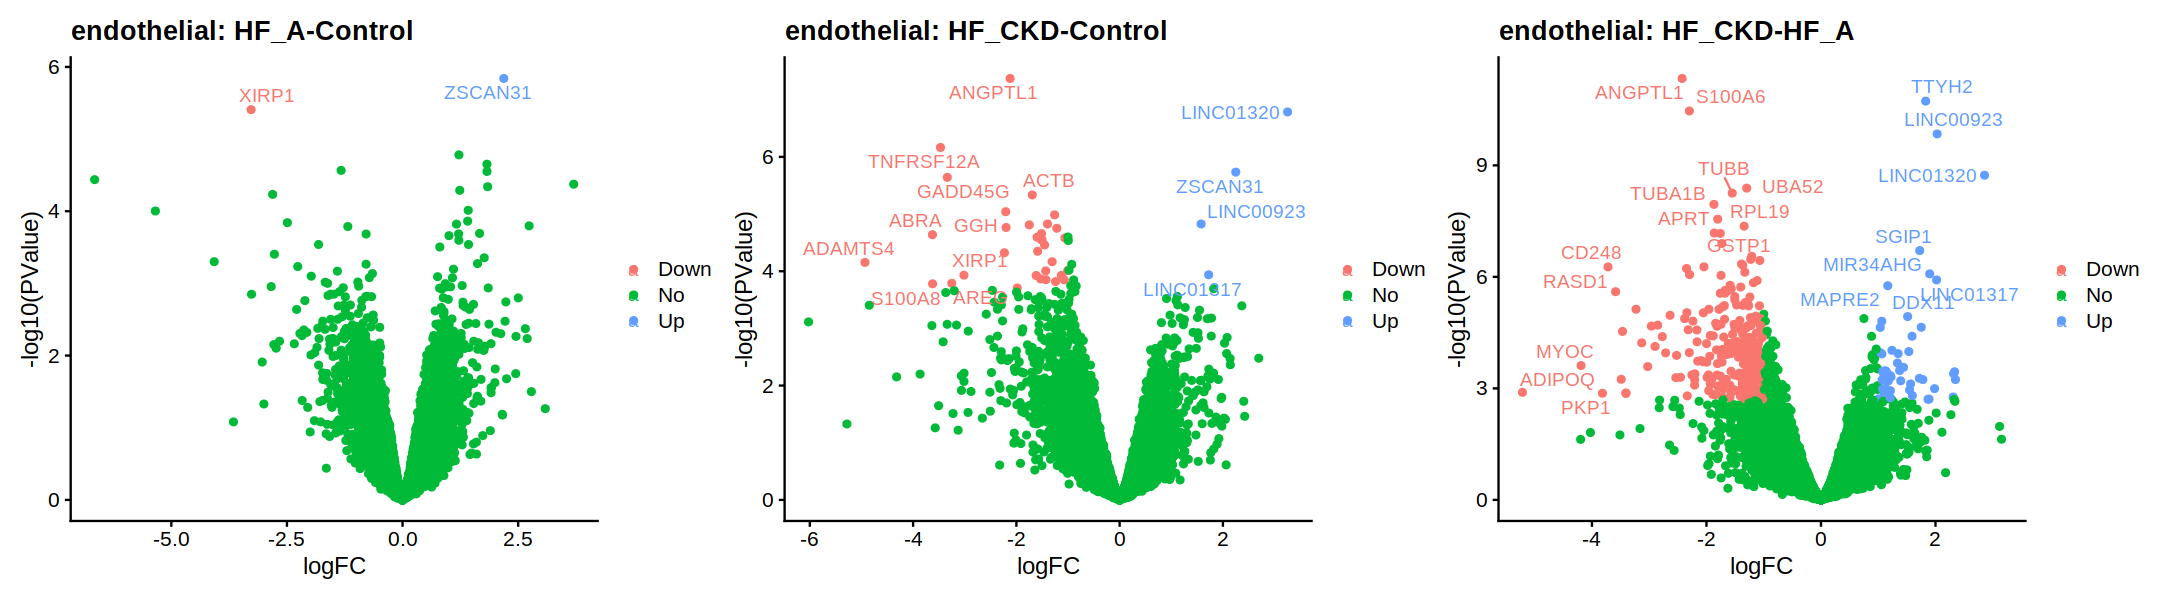

Warning message:
“Removed 14308 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 14301 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 14312 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 45 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 56 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 44 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 102 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 497 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


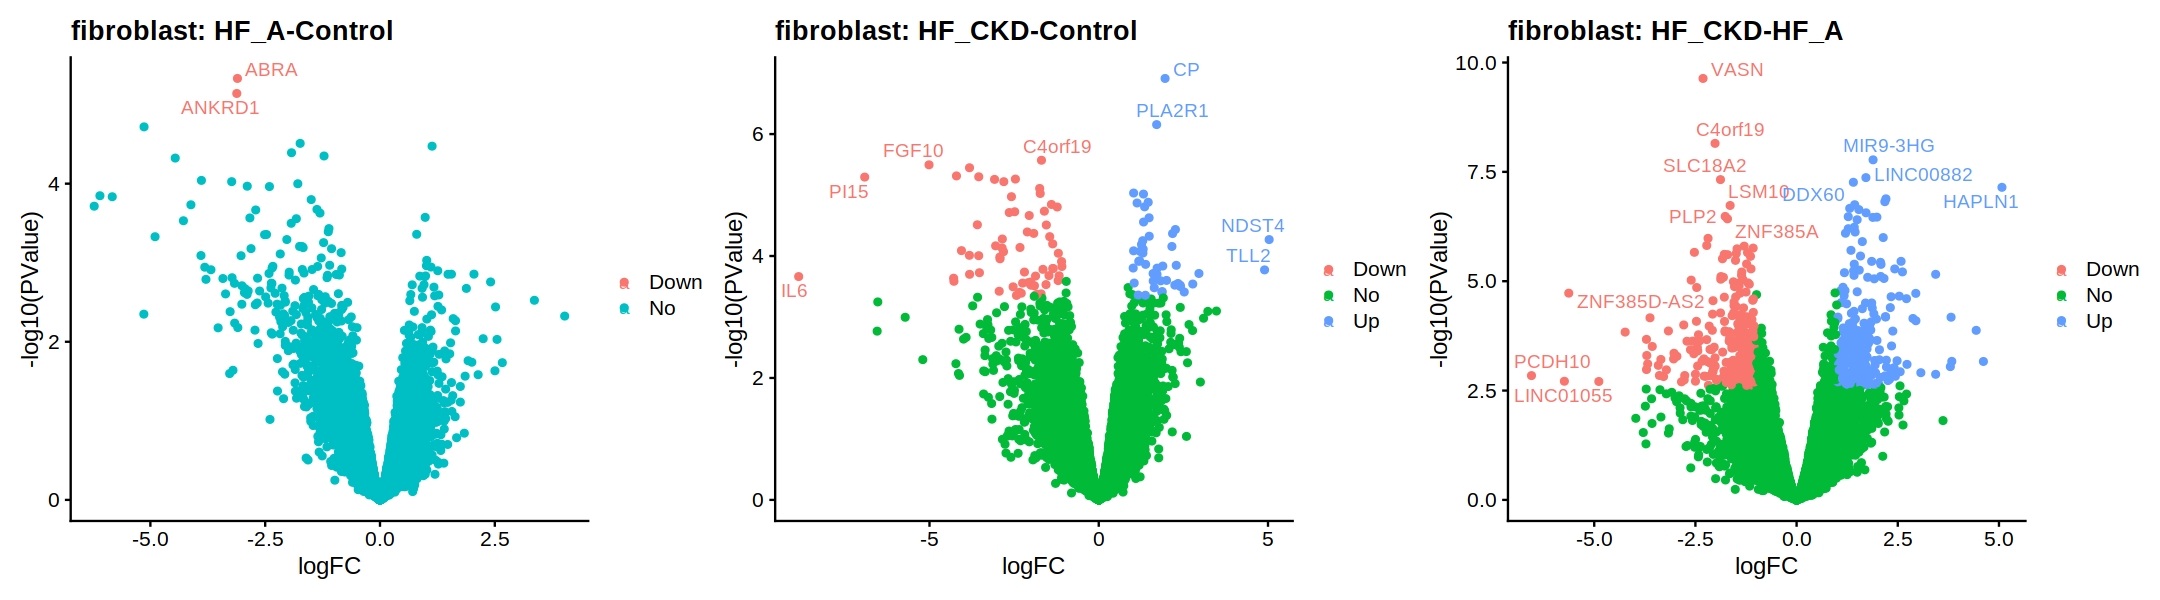

Warning message:
“Removed 3899 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 3893 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 3875 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 34 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 48 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 39 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


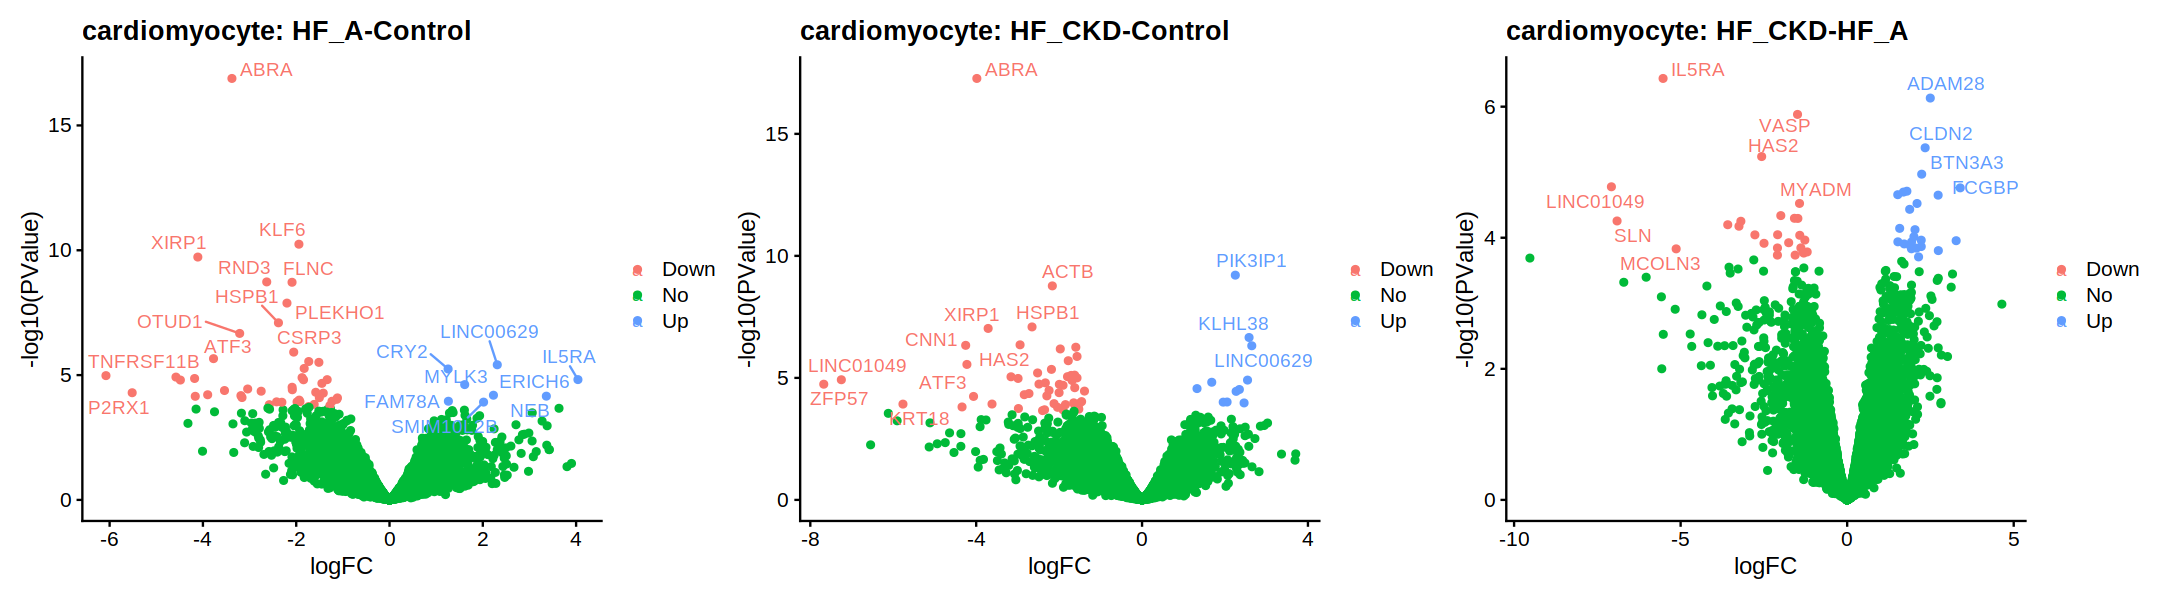

Warning message:
“Removed 6688 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 6644 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 6644 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 36 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 36 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


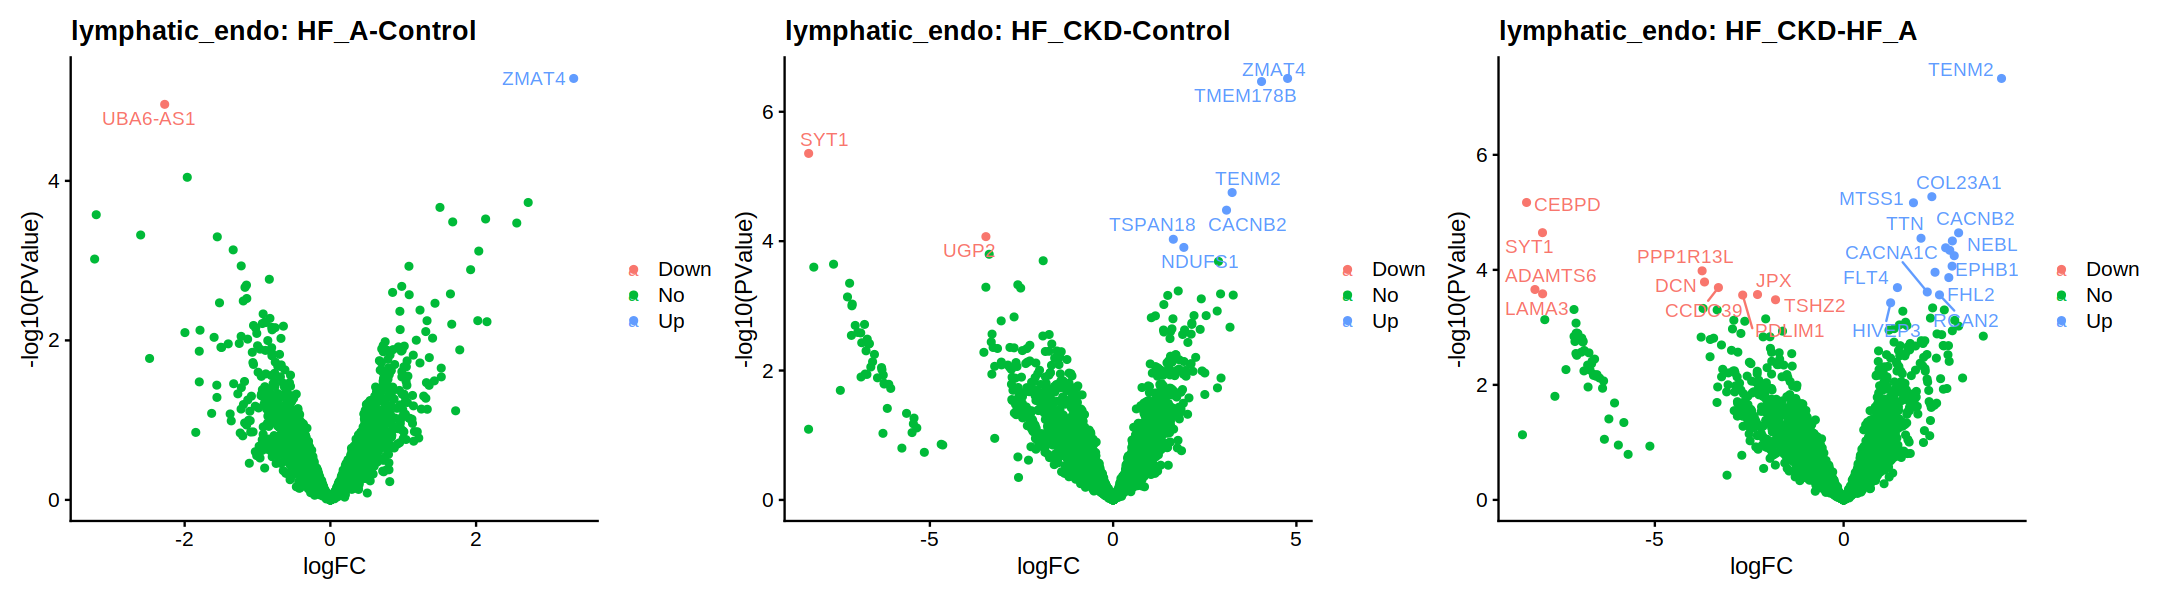

Warning message:
“Removed 5292 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 5295 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 5294 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 22 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 27 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


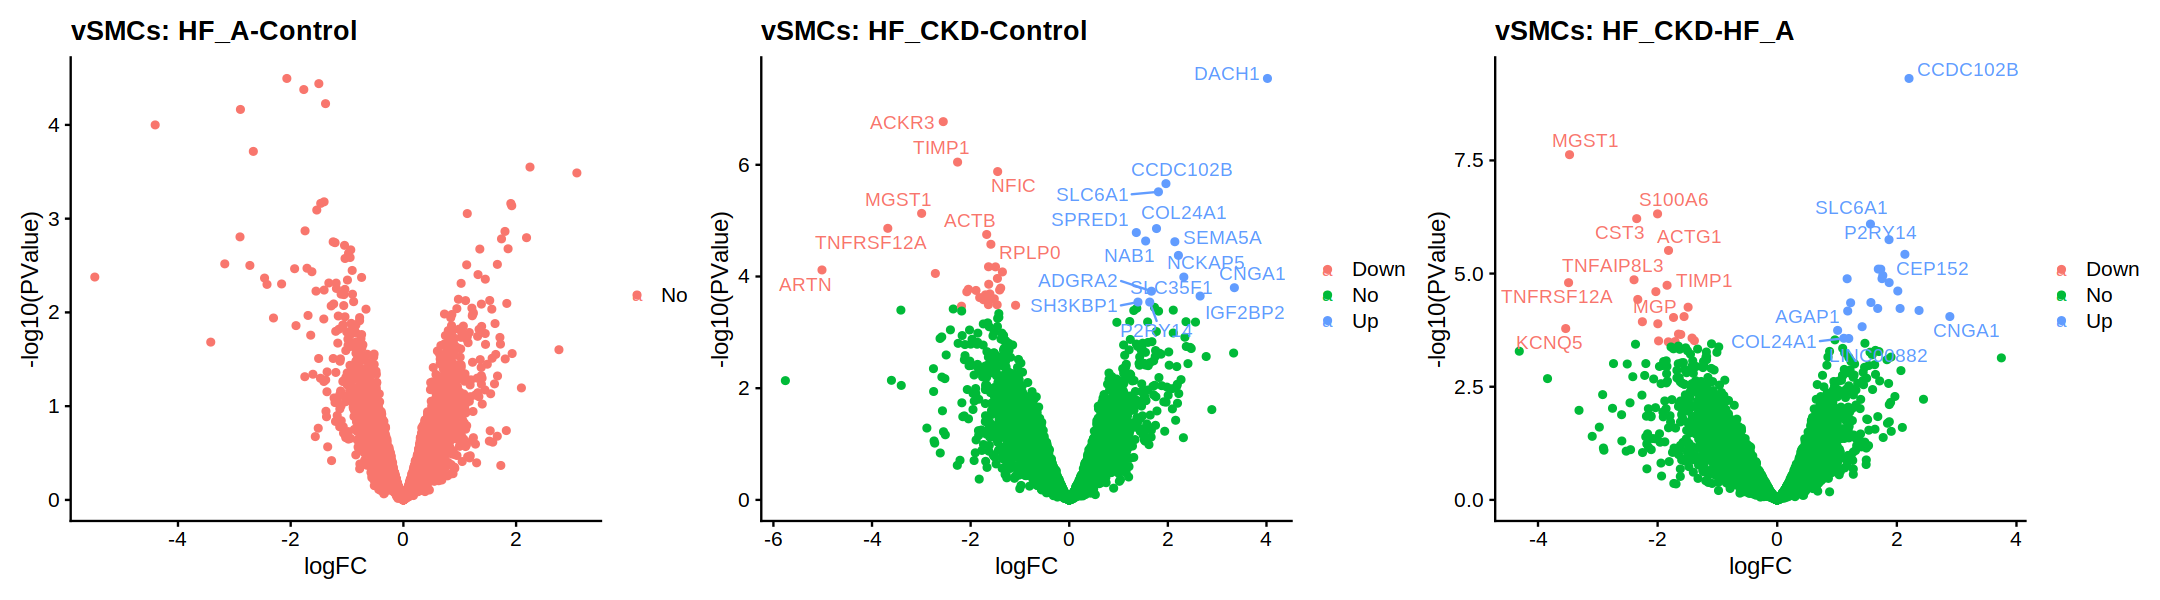

Warning message:
“Removed 1351 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 1345 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 1311 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 30 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


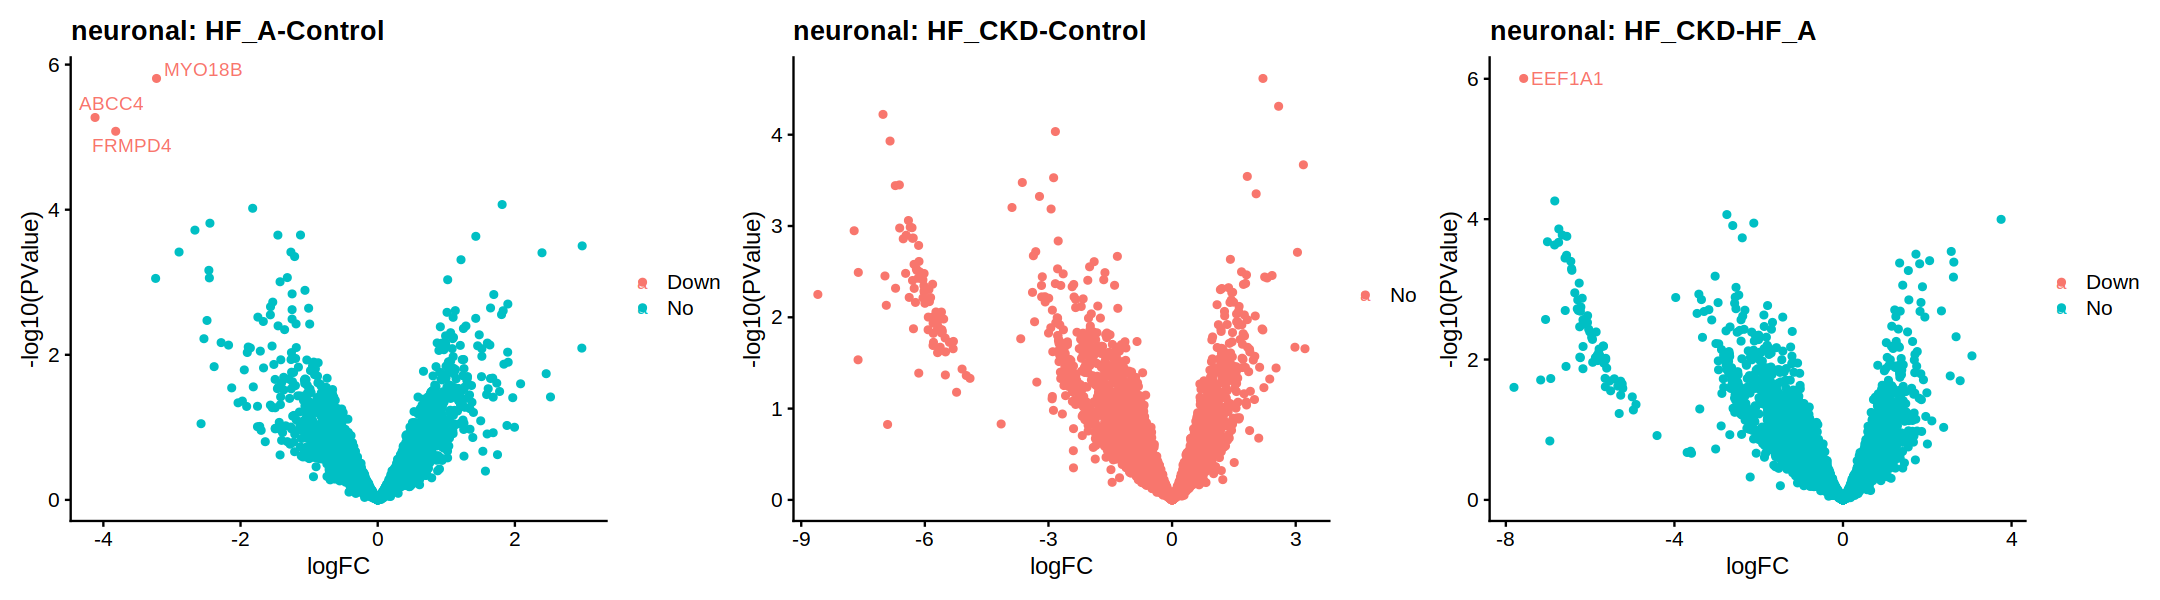

Warning message:
“Removed 10748 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11188 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 11169 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 443 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 26 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


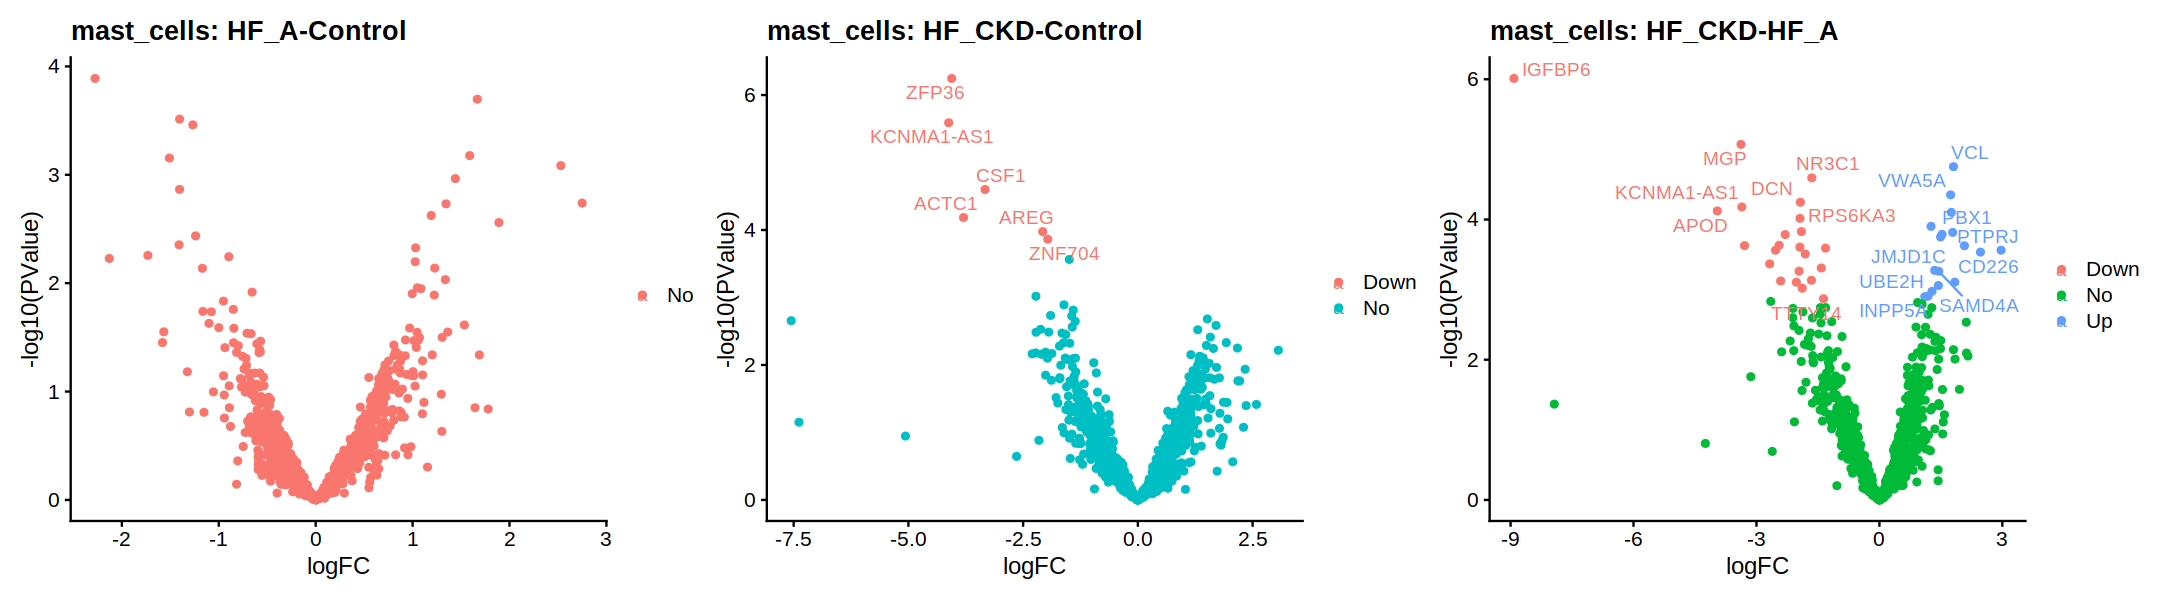

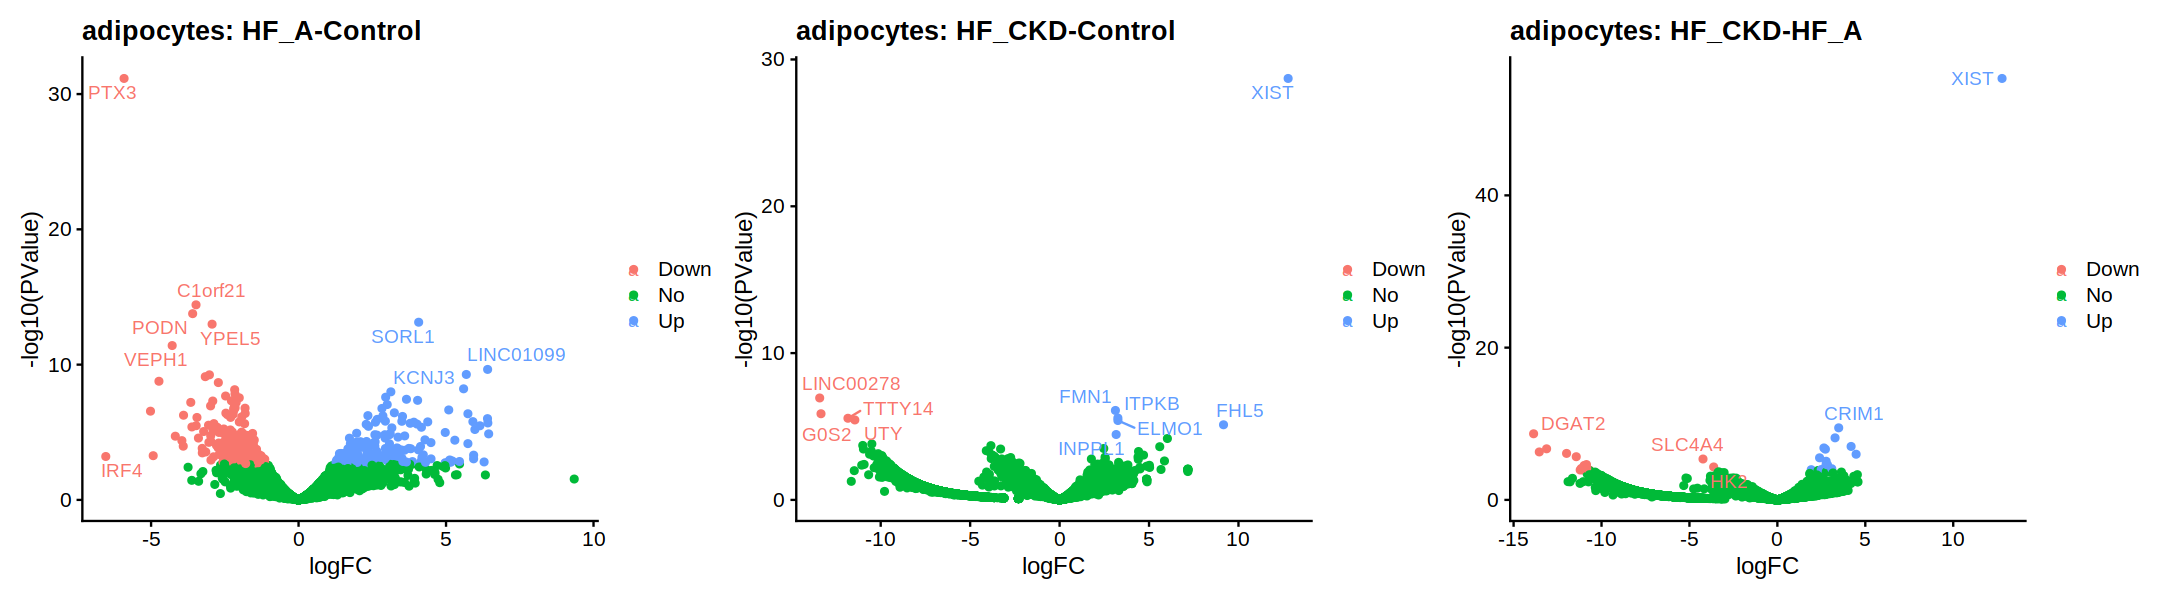

In [27]:
## visualize the DEGs
options(repr.plot.height = 5, repr.plot.width = 18)

for(celltype in celltype_list){
    plot_list <- lapply(c("HF_A-Control", "HF_CKD-Control", "HF_CKD-HF_A"), function(comparison){
        df <- readRDS(glue::glue("../data/DEG/{comparison}-{celltype}.rds"))
        
        # add a column for color
        df$diffexpressed <- "No"
        df$diffexpressed[df$logFC > 1 & df$FDR < 0.05] <- "Up"
        df$diffexpressed[df$logFC < -1 & df$FDR < 0.05] <- "Down"
        
        # add a column for label
        df$delabel <- NA
        df$delabel[df$diffexpressed != "No"] <- df$gene[df$diffexpressed != "No"]
        
        p <- ggplot(data = df, aes(x = logFC, y = -log10(PValue), col = diffexpressed, label = delabel)) +
                geom_point() +
                ggtitle(glue::glue("{celltype}: {comparison}")) +
        geom_text_repel() +
                theme_cowplot() +
                theme(legend.title = element_blank())
        
        return(p)
    })
    
    p <- patchwork::wrap_plots(plot_list)
    print(p)
}


# A tibble: 16 × 3
   de    count celltype      
   <chr> <int> <chr>         
 1 Down     14 pericyte      
 2 Up        4 pericyte      
 3 Down     14 macrophages   
 4 Up        5 macrophages   
 5 Down      3 T-cells       
 6 Up        5 T-cells       
 7 Down      1 endothelial   
 8 Up        1 endothelial   
 9 Down      2 fibroblast    
10 Down     46 cardiomyocyte 
11 Up        8 cardiomyocyte 
12 Down      1 lymphatic_endo
13 Up        1 lymphatic_endo
14 Down      3 neuronal      
15 Down    273 adipocytes    
16 Up      177 adipocytes    
# A tibble: 19 × 3
   de    count celltype      
   <chr> <int> <chr>         
 1 Down      2 pericyte      
 2 Up        1 pericyte      
 3 Down     12 macrophages   
 4 Up       10 macrophages   
 5 Down     49 T-cells       
 6 Up       32 T-cells       
 7 Down     33 endothelial   
 8 Up        4 endothelial   
 9 Down     64 fibroblast    
10 Up       46 fibroblast    
11 Down     50 cardiomyocyte 
12 Up       11 cardiomyocyte 
13

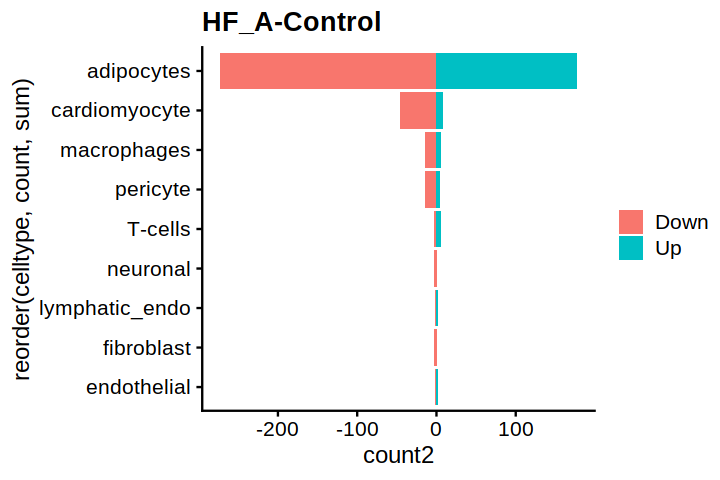

# A tibble: 21 × 3
   de    count celltype   
   <chr> <int> <chr>      
 1 Down    219 pericyte   
 2 Up       58 pericyte   
 3 Down     50 macrophages
 4 Up       58 macrophages
 5 Down    235 T-cells    
 6 Up      227 T-cells    
 7 Down    294 endothelial
 8 Up       48 endothelial
 9 Down    275 fibroblast 
10 Up      235 fibroblast 
# … with 11 more rows


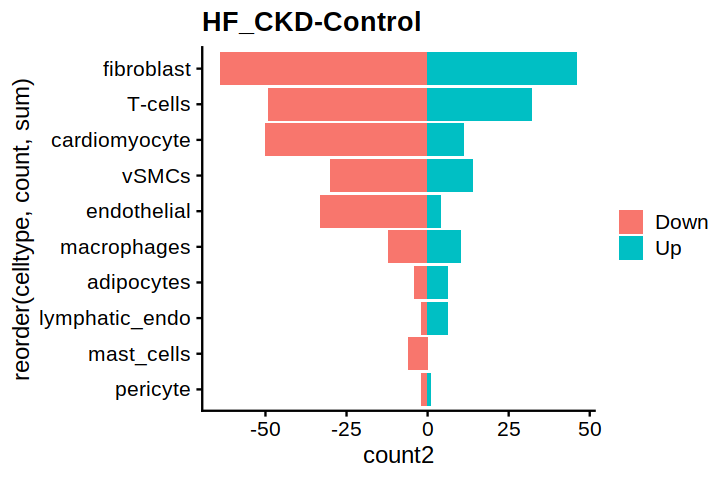

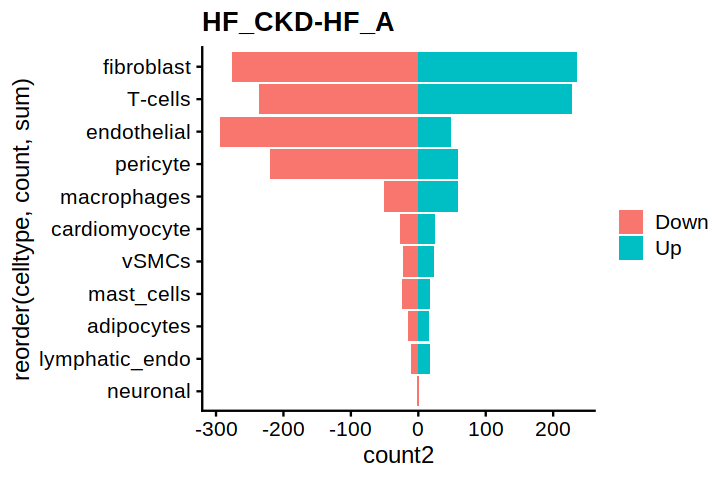

In [7]:
## plot number of DEGs
options(repr.plot.height = 4, repr.plot.width = 6)

for(comparison in c("HF_A-Control", "HF_CKD-Control", "HF_CKD-HF_A")){
    df_plot <- lapply(celltype_list, function(celltype){
        df <- readRDS(glue::glue("../data/DEG/{comparison}-{celltype}.rds")) %>%
            subset(abs(logFC) > 1 & FDR < 0.05)
        
        df$de <- ifelse(df$logFC > 0, "Up", "Down")
        df <- df %>%
            group_by(de) %>%
            summarise(count = n())
        
        df$celltype <- celltype
        
        return(df)
    }) %>% Reduce(rbind, .)
    
    print(df_plot)
    
    if(comparison == "HF_A-Control"){
        df_plot$count2 <- ifelse(df_plot$de == "Up", df_plot$count, -1*df_plot$count)
    } else if(comparison == "HF_CKD-Control"){
        df_plot$count2 <- ifelse(df_plot$de == "Up", df_plot$count, -1*df_plot$count)
    } else if(comparison == "HF_CKD-HF_A"){
        df_plot$count2 <- ifelse(df_plot$de == "Up", df_plot$count, -1*df_plot$count)
    }
    
    p <- ggplot(data = df_plot, aes(x = reorder(celltype, count, sum), y = count2, fill = de)) +
        geom_bar(stat = "identity")+
        ggtitle(comparison) +
      coord_flip() +
        theme_cowplot() +
        theme(legend.title = element_blank())
    
    print(p)
}